In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from IPython.display import display
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import geopandas as gpd
from shapely.geometry import Point

In [3]:
# Load the dataset
data = pd.read_csv("AccidentsBig.csv")
print(data.info())

/tmp/ipython-input-3332207592.py:2: DtypeWarning: Columns (8,10,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("AccidentsBig.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Accident_Index                               59998 non-null  float64
 1   longitude                                    59998 non-null  float64
 2   latitude                                     59998 non-null  float64
 3   Police_Force                                 59998 non-null  float64
 4   Accident_Severity                            59998 non-null  float64
 5   Number_of_Vehicles                           59998 non-null  float64
 6   Number_of_Casualties                         59998 non-null  float64
 7   Day_of_Week                                  59998 non-null  float64
 8   Time                                         59997 non-null  object 
 9   Local_Authority_(District)                   59998 non-null  float64

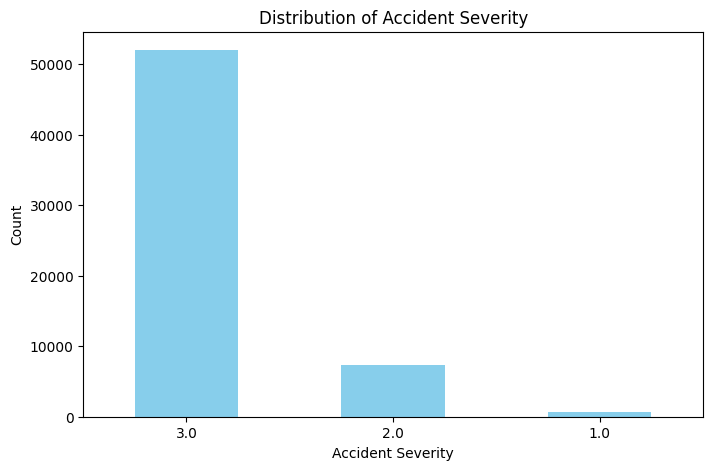

Accident Severity Distribution:
 Accident_Severity
3.0    51975
2.0     7377
1.0      646
Name: count, dtype: int64

Distribution for Weather_Conditions:
 Weather_Conditions
1.0    49807
2.0     7075
8.0      756
4.0      582
9.0      573
5.0      522
3.0      406
7.0      228
6.0       49
Name: count, dtype: int64

Distribution for Road_Type:
 Road_Type
6.0    45646
3.0     8783
1.0     2996
2.0     1631
9.0      472
7.0      470
Name: count, dtype: int64

Distribution for Light_Conditions:
 Light_Conditions
1.0    43180
4.0    14969
6.0     1352
7.0      253
5.0      244
Name: count, dtype: int64

Distribution for Road_Surface_Conditions:
 Road_Surface_Conditions
 1.0    43561
 2.0    15489
 4.0      617
 3.0      231
 5.0       50
-1.0       50
Name: count, dtype: int64


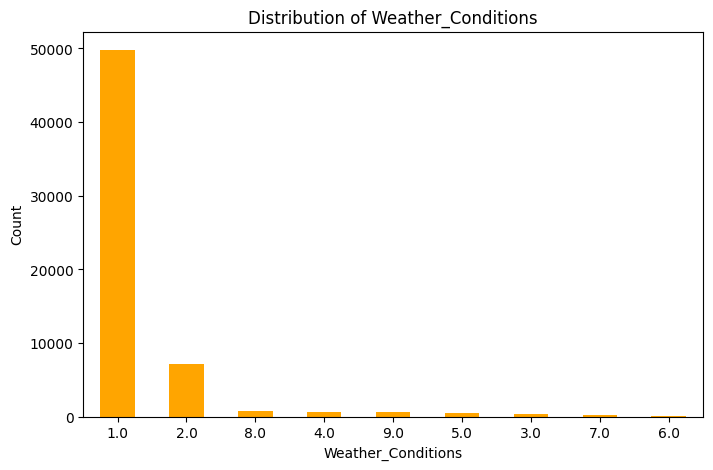

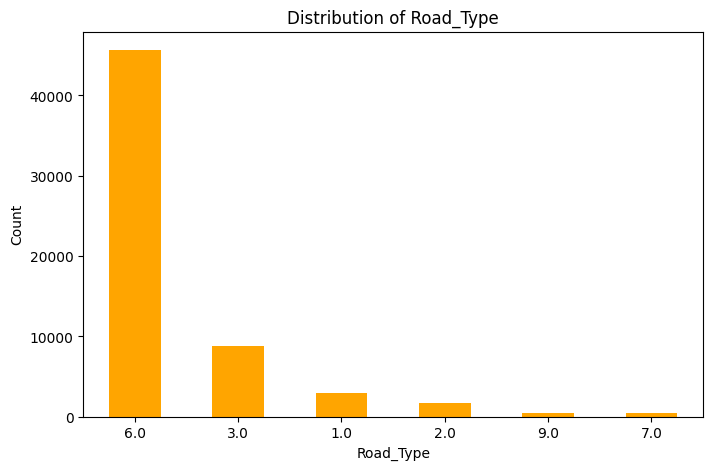

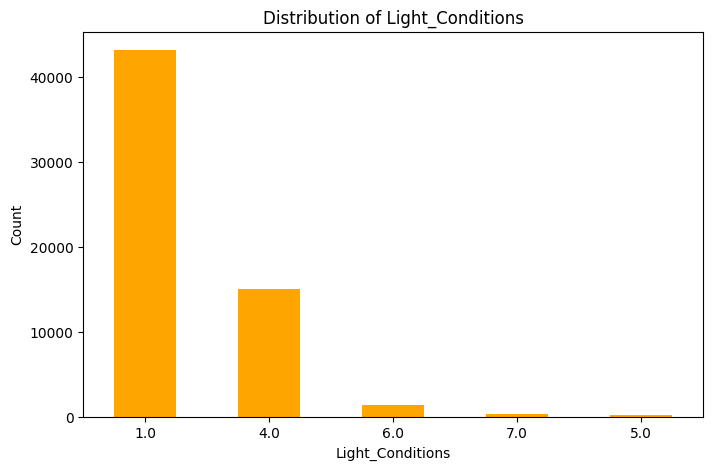

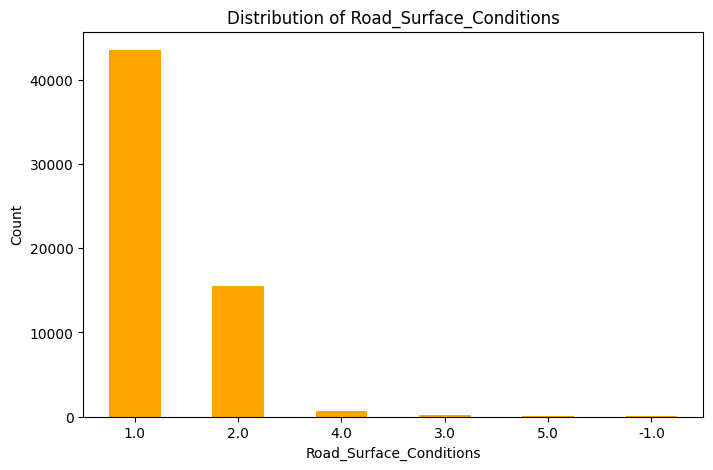

In [4]:
# Check balance in the target variable
target_column = 'Accident_Severity'
target_counts = data[target_column].value_counts()

# Visualize the distribution of the target variable
plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
print("Accident Severity Distribution:\n", target_counts)

# Check balance in other categorical features
categorical_columns = ['Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions']
for col in categorical_columns:
    print(f"\nDistribution for {col}:\n", data[col].value_counts())

# Visualize distributions of additional categorical features
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    data[col].value_counts().plot(kind='bar', color='orange')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()


In [5]:
# Handle null values
data.fillna(-1, inplace=True)

# Balance the `Accident_Severity` column
class_3 = data[data['Accident_Severity'] == 3.0]
class_2 = data[data['Accident_Severity'] == 2.0]
class_1 = data[data['Accident_Severity'] == 1.0]

# Oversample minority classes
class_2_oversampled = resample(class_2, replace=True, n_samples=len(class_3), random_state=42)
class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_3), random_state=42)

# Combine the classes into a balanced dataset
balanced_data = pd.concat([class_3, class_2_oversampled, class_1_oversampled])

# Select relevant features for clustering, including `Accident_Severity`
features = ['longitude', 'latitude', 'Weather_Conditions', 'Road_Type', 'Light_Conditions',
            'Road_Surface_Conditions', 'Accident_Severity']
balanced_data = balanced_data[features]

# Handle remaining invalid values
columns_to_replace = ['Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions','Accident_Severity']
balanced_data[columns_to_replace] = balanced_data[columns_to_replace].replace(-1, balanced_data[columns_to_replace].mean())

# Save the balanced dataset for clustering
balanced_data.to_csv('Balanced_Accidents_Cluster.csv', index=False)

# Display the balanced dataset summary
print("Balanced Dataset Summary:")
print(balanced_data.describe())

# Check class balance (optional)
print("\nBalanced Dataset Feature Distribution:")
print(balanced_data['Accident_Severity'].value_counts())


Balanced Dataset Summary:
           longitude       latitude  Weather_Conditions      Road_Type  \
count  155925.000000  155925.000000       155925.000000  155925.000000   
mean       77.051528      22.813885            1.382633       5.279237   
std         5.084122       5.216820            1.258687       1.486050   
min        69.015103       8.864429            1.000000       1.000000   
25%        73.823835      18.609859            1.000000       6.000000   
50%        76.637100      23.024054            1.000000       6.000000   
75%        77.328107      28.413755            1.000000       6.000000   
max        94.231931      31.068800            9.000000       9.000000   

       Light_Conditions  Road_Surface_Conditions  Accident_Severity  
count     155925.000000            155925.000000      155925.000000  
mean           2.159756                 1.321091           2.000000  
std            1.653117                 0.550566           0.816499  
min            1.000000    

In [6]:
# Continuous features
continuous_features = ['longitude', 'latitude']

# Discrete features
discrete_features = ['Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions', 'Accident_Severity']

# Continuous feature summary
print("Continuous Feature Summary:")
print(balanced_data[continuous_features].describe())

# Discrete feature distribution
print("\nDiscrete Feature Distribution:")
for feature in discrete_features:
    print(f"\n{feature} Distribution:")
    print(balanced_data[feature].value_counts())


Continuous Feature Summary:
           longitude       latitude
count  155925.000000  155925.000000
mean       77.051528      22.813885
std         5.084122       5.216820
min        69.015103       8.864429
25%        73.823835      18.609859
50%        76.637100      23.024054
75%        77.328107      28.413755
max        94.231931      31.068800

Discrete Feature Distribution:

Weather_Conditions Distribution:
Weather_Conditions
1.0    130530
2.0     16858
4.0      2040
5.0      1601
9.0      1562
8.0      1530
3.0       866
7.0       652
6.0       286
Name: count, dtype: int64

Road_Type Distribution:
Road_Type
6.0    119737
3.0     25506
1.0      5324
2.0      3307
7.0      1086
9.0       965
Name: count, dtype: int64

Light_Conditions Distribution:
Light_Conditions
1.0    101764
4.0     44971
6.0      7566
5.0       826
7.0       798
Name: count, dtype: int64

Road_Surface_Conditions Distribution:
Road_Surface_Conditions
1.000000    110185
2.000000     43150
4.000000      1676
3

In [7]:
from sklearn.preprocessing import StandardScaler

# Select non-spatial features for scaling (excluding Accident_Severity)
features_to_scale = ['Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions']
scaler = StandardScaler()
balanced_data[features_to_scale] = scaler.fit_transform(balanced_data[features_to_scale])

# Save the scaled dataset for clustering
balanced_data.to_csv('Balanced_Accidents_Scaled.csv', index=False)

print("Features scaled (excluding Accident_Severity) and saved for clustering!")


Features scaled (excluding Accident_Severity) and saved for clustering!


In [9]:
file_path = 'Balanced_Accidents_Scaled.csv'
data = pd.read_csv(file_path)

# Preserve the target variable
target = data['Accident_Severity']

# Select features for clustering
features = ['longitude', 'latitude', 'Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions']
X = data[features]

# Scale non-geographical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions']] = scaler.fit_transform(
    X[['Weather_Conditions', 'Road_Type', 'Light_Conditions', 'Road_Surface_Conditions']]
)

In [10]:
# Applying DBSCAN with adjusted parameters
dbscan = DBSCAN(eps=0.5, min_samples=20)
data['Cluster'] = dbscan.fit_predict(X_scaled)

# Evaluate clustering results
n_clusters = len(set(data['Cluster'])) - (1 if -1 in data['Cluster'] else 0)
n_noise = list(data['Cluster']).count(-1)

print(f"Estimated number of clusters after tuning: {n_clusters}")
print(f"Number of noise points after tuning: {n_noise}")

Estimated number of clusters after tuning: 407
Number of noise points after tuning: 7726


In [11]:
# Calculate Silhouette Score (excluding noise points)
if n_clusters > 1:
    score = silhouette_score(X_scaled[data['Cluster'] != -1], data['Cluster'][data['Cluster'] != -1])
    print(f"Silhouette Score: {score:.3f}")
else:
    print("Not enough clusters to calculate Silhouette Score.")


Silhouette Score: 0.882



Cluster Summary:
     Cluster  Severity_Mean  Cluster_Size  Latitude_Mean  Longitude_Mean
0         -1       2.501683          7726      22.076703       77.783745
1          0       2.399015           203      14.722200       78.550715
2          1       2.468593           796      14.732077       78.552680
3          2       2.529252          1846      14.729878       78.554048
4          3       2.525140           179      14.725074       78.566600
..       ...            ...           ...            ...             ...
402      401       1.000000            87      26.467291       74.650711
403      402       1.000000            75      19.141558       72.830493
404      403       1.000000            86      27.632833       79.649385
405      404       1.000000            84      18.712603       70.906904
406      405       1.000000           101      27.858457       83.112098

[407 rows x 5 columns]


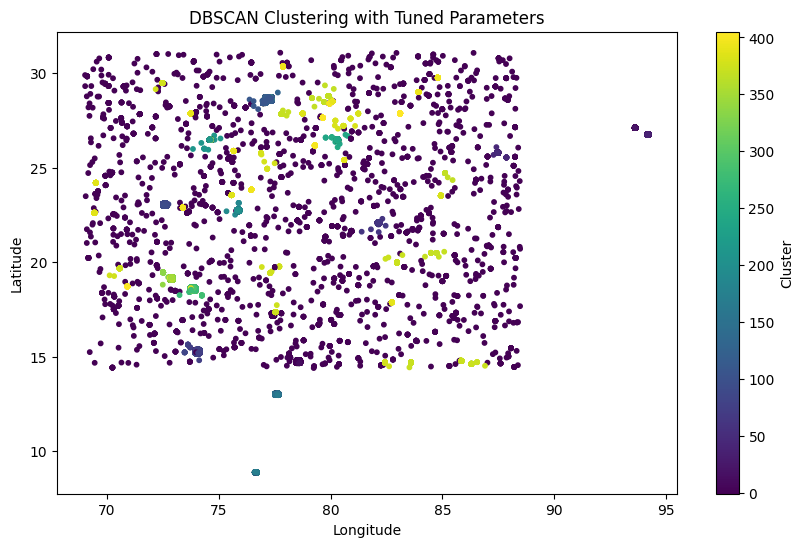

Clustered dataset saved to Clustered_Accidents_With_Severity.csv


In [12]:
#Analyze clusters based on Accident Severity
cluster_summary = data.groupby('Cluster').agg({
    'Accident_Severity': ['mean', 'count'],
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Flatten multi-level columns
cluster_summary.columns = ['Cluster', 'Severity_Mean', 'Cluster_Size', 'Latitude_Mean', 'Longitude_Mean']
print("\nCluster Summary:")
print(cluster_summary)

# Step 7: Visualize the updated clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['longitude'], data['latitude'], c=data['Cluster'], cmap='viridis', s=10)
plt.title('DBSCAN Clustering with Tuned Parameters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# Step 8: Save the updated dataset
output_file = 'Clustered_Accidents_With_Severity.csv'
data.to_csv(output_file, index=False)
print(f"Clustered dataset saved to {output_file}")

In [13]:
#Analyze Cluster Characteristics
cluster_summary = data.groupby('Cluster').agg({
    'longitude': 'mean',
    'latitude': 'mean',
    'Weather_Conditions': 'mean',
    'Road_Type': 'mean',
    'Light_Conditions': 'mean',
    'Road_Surface_Conditions': 'mean',
    'Accident_Severity': ['mean', 'count']
}).reset_index()

cluster_summary.columns = [
    'Cluster', 'Longitude_Mean', 'Latitude_Mean', 'Weather_Mean',
    'Road_Type_Mean', 'Light_Conditions_Mean', 'Road_Surface_Mean',
    'Accident_Severity_Mean', 'Cluster_Size'
]
print(cluster_summary.head())


   Cluster  Longitude_Mean  Latitude_Mean  Weather_Mean  Road_Type_Mean  \
0       -1       77.783745      22.076703      1.451659       -0.232501   
1        0       78.550715      14.722200     -0.303994       -1.533760   
2        1       78.552680      14.732077     -0.303994        0.485021   
3        2       78.554048      14.729878     -0.303994        0.485021   
4        3       78.566600      14.725074      0.490487        0.485021   

   Light_Conditions_Mean  Road_Surface_Mean  Accident_Severity_Mean  \
0               0.407512           0.967543                2.501683   
1               1.113200          -0.583203                2.399015   
2               1.113200          -0.583203                2.468593   
3              -0.701560          -0.583203                2.529252   
4              -0.701560           1.233116                2.525140   

   Cluster_Size  
0          7726  
1           203  
2           796  
3          1846  
4           179  


In [14]:
# Load the GeoJSON file
geojson_path = 'states_india.json'
india_states = gpd.read_file(geojson_path)

# Ensure the CRS of the GeoJSON file
india_states = india_states.to_crs("EPSG:4326")

# Load the accident dataset
data_path = 'Clustered_Accidents_With_Severity.csv'
data = pd.read_csv(data_path)

# Convert the accident data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
data_gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# Perform a spatial join to assign state names
data_with_states = gpd.sjoin(data_gdf, india_states, how='left', predicate='within')

# Save the updated dataset with state names
output_path = 'Accidents_With_States.csv'
data_with_states.to_csv(output_path, index=False)

print(f"Updated dataset saved to: {output_path}")

Updated dataset saved to: Accidents_With_States.csv


In [15]:
file_path = 'Accidents_With_States.csv'
data = pd.read_csv(file_path)
# Display the first few rows to understand the structure of the data
data.head()


,longitude,latitude,Weather_Conditions,Road_Type,Light_Conditions,Road_Surface_Conditions,Accident_Severity,Cluster,geometry,index_right,cartodb_id,state_code,st_nm
0,78.534042,14.762353,-0.303994,-1.533760,1.113200,-0.583203,3.0,0,POINT (78.53404158 14.76235346),2.0,3.0,28.0,Andhra Pradesh
1,78.470877,14.745606,-0.303994,0.485021,1.113200,-0.583203,3.0,1,POINT (78.47087739 14.74560635),2.0,3.0,28.0,Andhra Pradesh
2,78.557994,14.667128,-0.303994,0.485021,-0.701560,-0.583203,3.0,2,POINT (78.55799399 14.66712796),2.0,3.0,28.0,Andhra Pradesh
3,78.576431,14.703443,-0.303994,0.485021,2.927959,1.233116,3.0,-1,POINT (78.57643143 14.70344275),2.0,3.0,28.0,Andhra Pradesh
4,78.531051,14.737359,0.490487,0.485021,-0.701560,1.233116,3.0,3,POINT (78.53105133 14.73735895),2.0,3.0,28.0,Andhra Pradesh


In [16]:
# Drop missing values
data_cleaned = data.dropna()

# Display the shape of the cleaned data to confirm missing values are removed
data_cleaned.shape

(154036, 13)

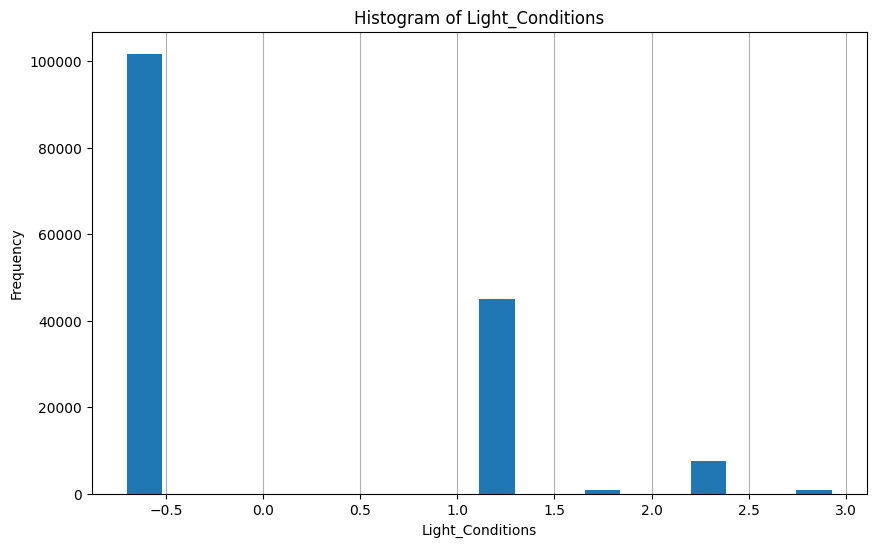

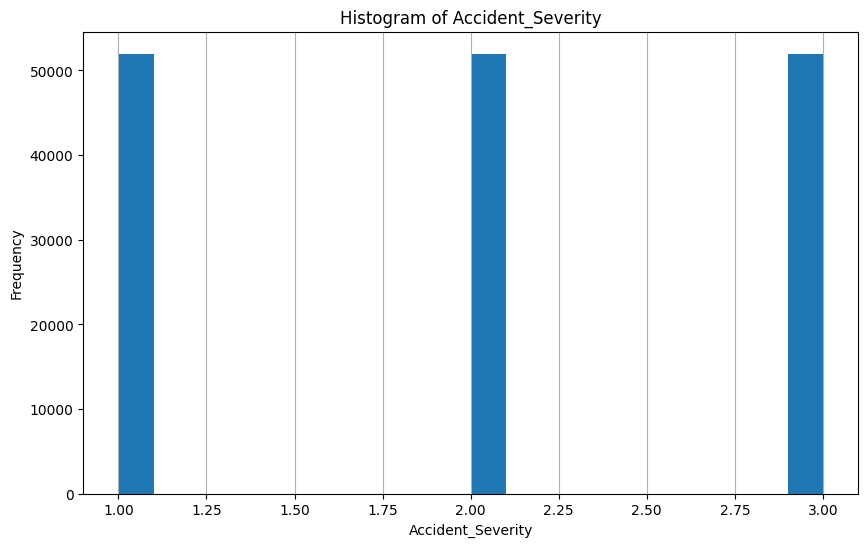

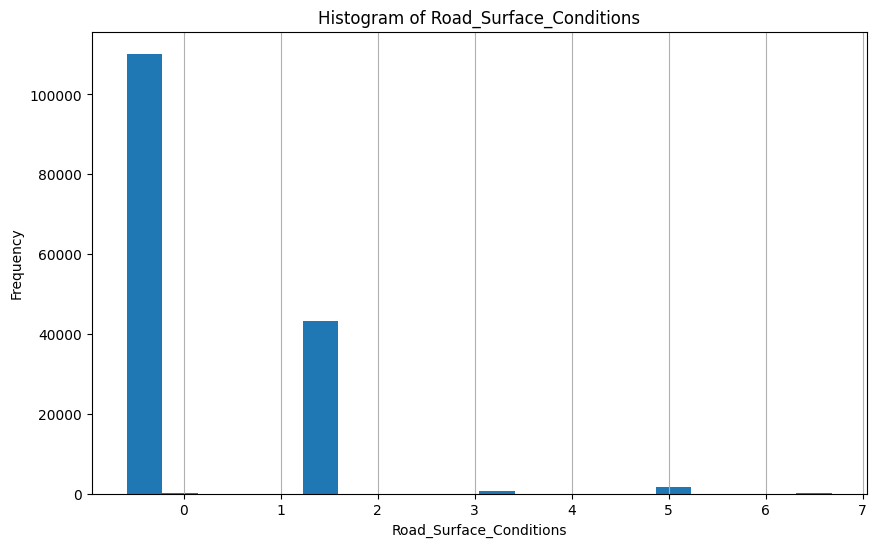

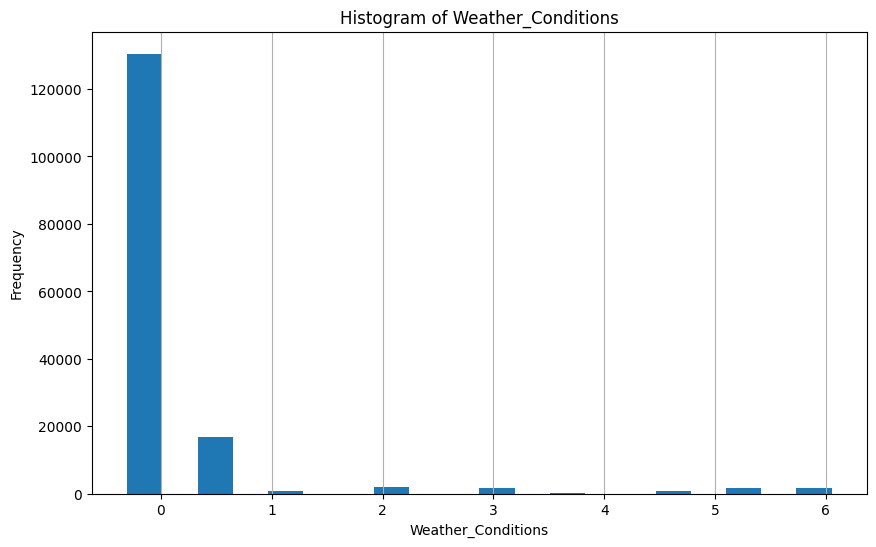

In [18]:
# Columns to visualize
columns_to_visualize = ['Light_Conditions', 'Accident_Severity', 'Road_Surface_Conditions', 'Weather_Conditions']

# Visualize specified columns
def visualize_selected_columns(data, columns):
    for column in columns:
        plt.figure(figsize=(10, 6))
        if data[column].dtype == 'object':  # Categorical data
            data[column].value_counts().plot(kind='bar')
            plt.title(f'Bar Plot of {column}')
            plt.ylabel('Count')
        else:  # Numerical data
            data[column].hist(bins=20)
            plt.title(f'Histogram of {column}')
            plt.ylabel('Frequency')
        plt.xlabel(column)
        plt.grid(axis='y')
        plt.show()

visualize_selected_columns(data, columns_to_visualize)

In [19]:
# Grouping clusters into risk categories based on Accident_Severity
def categorize_risk(severity):
    if severity >= 3:
        return "High Risk"
    elif severity == 2:
        return "Medium Risk"
    else:
        return "Low Risk"

# Apply risk categorization
data_cleaned['Risk_Category'] = data_cleaned['Accident_Severity'].apply(categorize_risk)

# Count the number of clusters in each risk category
risk_category_counts = data_cleaned['Risk_Category'].value_counts()

# Display the counts
risk_category_counts


,count
Risk_Category,
High Risk,51638
Medium Risk,51412
Low Risk,50986


In [20]:
# Define a function to translate reason codes into descriptive text
def translate_reason(row):
    reasons = []
    if row['Weather_Conditions'] < 0:
        reasons.append("Bad Weather")
    if row['Road_Type'] < 0:
        reasons.append("Bad Road Condition")
    if row['Light_Conditions'] < 0:
        reasons.append("Poor Lighting")
    return ", ".join(reasons) if reasons else "Unknown"

# Apply translation to the dataset
data_cleaned['Descriptive_Reason'] = data_cleaned.apply(translate_reason, axis=1)

# Initialize a new map centered in India
m_subset_clusters = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# Function to get 5 clusters from 5 different states for each risk category
def get_sample_clusters(risk_category):
    return data_cleaned[data_cleaned['Risk_Category'] == risk_category] \
        .groupby('st_nm').head(1).head(10)

# Get sample clusters for each risk category
high_risk_clusters = get_sample_clusters("High Risk")
medium_risk_clusters = get_sample_clusters("Medium Risk")
low_risk_clusters = get_sample_clusters("Low Risk")

# Add clusters to the map
for _, row in pd.concat([high_risk_clusters, medium_risk_clusters, low_risk_clusters]).iterrows():
    popup_info = (
        f"Latitude: {row['latitude']}<br>"
        f"Longitude: {row['longitude']}<br>"
        f"Reason: {row['Descriptive_Reason']}<br>"
        f"State: {row['st_nm']}"
    )
    # Set marker color based on risk category
    marker_color = "red" if row['Risk_Category'] == "High Risk" else \
                   "orange" if row['Risk_Category'] == "Medium Risk" else "green"

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_info,
        icon=folium.Icon(color=marker_color)
    ).add_to(m_subset_clusters)

# Save the map
#m_subset_clusters.save('subset_clusters_map.html')

# Display the map in the notebook
m_subset_clusters